In [7]:
import pandas as pd
df = pd.read_csv("cardinality_benchmark.tsv", sep="\t")

df["memory"] = 2**df.precision * df.bits
df["label"] = "HLL"

df

,precision,bits,exact,hll,mle,nn,memory,label
0,8,6,42156,34932.480,35220.203,32249.0760,1536,HLL
1,8,6,41286,38823.050,39088.293,35839.3200,1536,HLL
2,8,6,50193,48058.280,47923.758,44361.6560,1536,HLL
3,8,6,43799,42339.727,42611.395,39084.5350,1536,HLL
4,8,6,11477,11385.202,11410.331,10519.4770,1536,HLL
...,...,...,...,...,...,...,...,...
995,8,6,3591,3524.602,3528.330,3265.6584,1536,HLL
996,8,6,10913,10343.806,10379.179,9558.4690,1536,HLL
997,8,6,26735,24805.870,25014.912,22904.1660,1536,HLL
998,8,6,20049,19638.902,19761.277,18136.0500,1536,HLL


In [22]:
import pandas as pd
import numpy as np

samples = pd.read_csv("experiments/cardinality_model/samples.tsv", sep="\t")

samples["mse_rates"] = ((samples.ground - samples.model)**2 / (samples.ground - samples.hll)**2)

(samples["mse_rates"] > 1.0).mean()

0.484

<Axes: >

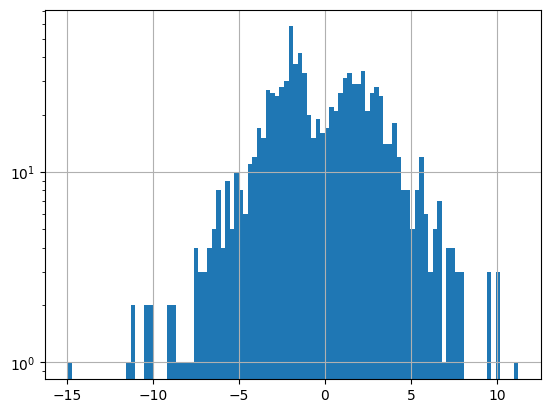

In [21]:
import matplotlib.pyplot as plt
samples.mse_rates.hist(log=True, bins=100)

In [8]:
df["hll"] /= df.exact
df["mle"] /= df.exact
df["nn"] /= df.exact
df["exact"] /= df.exact
df["squared_error_hll"] = (df.exact - df.hll)**2
df["squared_error_mle"] = (df.exact - df.mle)**2
df["squared_error_nn"] = (df.exact - df.nn)**2
columns = ["squared_error_hll", "squared_error_mle", "squared_error_nn"]
data_hll = df.groupby(["precision", "bits", "memory"])[columns].agg(["mean", "std"])
data_hll = data_hll.reset_index()
data_hll

precision bits memory squared_error_hll           squared_error_mle  \
                                     mean       std              mean   
0         8    6   1536          0.004652  0.005434           0.00442   

            squared_error_nn            
        std             mean       std  
0  0.005189         0.015637  0.014054

KeyError: 'hash_name'

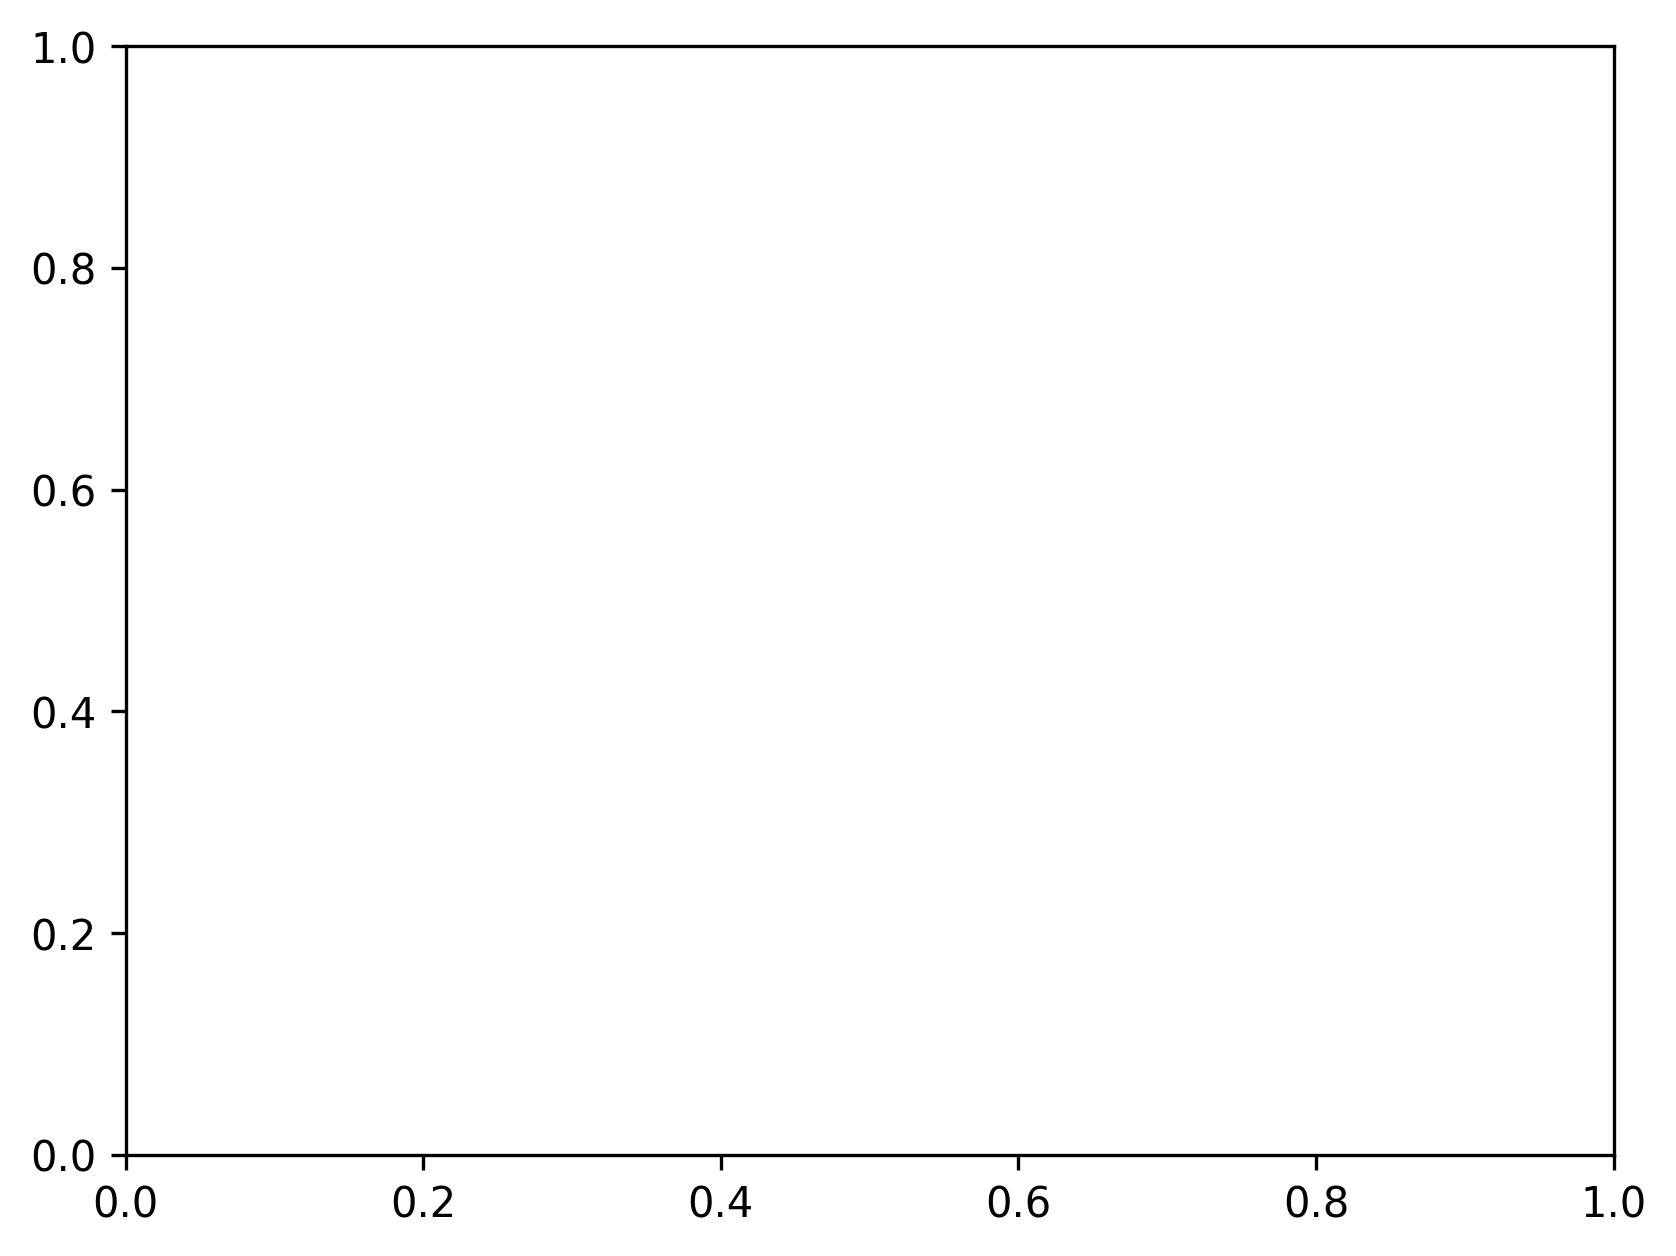

In [6]:
import matplotlib.pyplot as plt

bits_to_skip = (1, 2, 3, 4, 5)


for scale in ("log", "linear"):
    for bits in data_hll["bits"].unique():
        if bits in bits_to_skip:
            continue
        fig, axes = plt.subplots(dpi=300)
        for column in columns:
            for hash_name in data_hll["hash_name"].unique():
                filtered = data_hll[data_hll.bits == bits]
                linestyle = "-" if column == "squared_error_hll" else "--"
                filtered = filtered[filtered.hash_name == hash_name]
                short_hash_name = hash_name.split(":")[-1]
                if len(data_hll["hash_name"].unique()) == 1:
                    short_hash_name = ""
                c = column.split("_")[-1]
                plt.errorbar(
                    filtered.memory,
                    filtered[column]["mean"],
                    filtered[column]["std"],
                    linestyle=linestyle,
                    #marker=hash_name_marker_style[short_hash_name],
                    label=f"{bits}b, {c}, {short_hash_name}",
                    alpha=0.5
                )

        plt.legend()
        plt.xscale("log")
        plt.yscale(scale)
        plt.ylabel("Cardinality MSE over 1000 random sets")
        plt.xlabel(f"Memory required ({bits}b)")
        plt.show()